In [7]:
from src.uts import parse_files
from pathlib import Path
from bs4 import BeautifulSoup
import pandas as pd

import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
from src.utils import read_jsonl
from collections import defaultdict

In [8]:
uts = parse_files(list(Path('data/tsv/').glob('*.tsv')))
rows = []
for ut in uts:
    soup = BeautifulSoup(ut[2], features='xml')
    for t in soup.find_all('span'):
        if 'ana' in t.attrs and t.attrs['type'] not in ['NULL', 'NEUTRAL', 'CIVILITY']:
            rows.append((soup.find('u').attrs['who'], t.attrs['ana'], t.attrs['type']))
df_golds = pd.DataFrame(rows, columns=['speaker', 'target', 'type'])
df_golds.head()

,speaker,target,type
0,#vedel_georges,#segalat_andre,POSITIF
1,#lecourt_robert,#segalat_andre,NEGATIF
2,#segalat_andre,#lecourt_robert,NEGATIF
3,#vedel_georges,#lecourt_robert,NEGATIF
4,#vedel_georges,#gros_louis,POSITIF


In [9]:
rows = []
uts = read_jsonl('data/zeroshot/camembert-base-xnli_h_semble_chunk_.jsonl')
LABEL_TO_STR = {0:'POSITIF', 1:'NEGATIF', 2:'NEUTRAL'}
for ut in uts:
    label = ut['labels'][0]
    if label != 2:
        rows.append((ut['speaker'], ut['target'], LABEL_TO_STR[label]))
df_preds = pd.DataFrame(rows, columns=['speaker', 'target', 'type'])
df_preds.head()

,speaker,target,type
0,#frey_roger,#segalat_andre,POSITIF
1,#frey_roger,#segalat_andre,NEGATIF
2,#vedel_georges,#segalat_andre,POSITIF
3,#segalat_andre,#lecourt_robert,POSITIF
4,#vedel_georges,#gros_louis,POSITIF


In [10]:
def compute_agreements(inputs):
    outputs = []

    for speaker in inputs.speaker.unique():
        speaker_inputs = inputs[inputs['speaker']==speaker]
        rows = []
        for target in speaker_inputs.target.unique():
            target_inputs = speaker_inputs[speaker_inputs['target'] == target]
            rows.append((
                speaker, 
                target, 
                len(target_inputs[target_inputs['type']=='POSITIF']) / len(target_inputs) * 100, # Agreement %
                len(target_inputs) # support
            ))

        outputs.append(pd.DataFrame(rows, columns=['speaker', 'target', 'agreement', 'support']))

    outputs = pd.concat(outputs)
    outputs['agreement'] = outputs['agreement'].apply(lambda x: round(x, 2))
    
    return outputs

In [11]:
gold_agreements = compute_agreements(df_golds)
pred_agreements = compute_agreements(df_preds)

In [12]:
gold_agreements[gold_agreements['support'] > 4].sort_values('agreement', ascending=False)

,speaker,target,agreement,support
1,#segalat_andre,#vedel_georges,92.86,14
1,#jozeau-marigne_leon,#vedel_georges,80.00,5
1,#vedel_georges,#lecourt_robert,71.43,7
0,#segalat_andre,#lecourt_robert,71.43,7
1,#gros_louis,#lecourt_robert,66.67,9
1,#lecourt_robert,#vedel_georges,60.00,5
3,#gros_louis,#vedel_georges,57.14,7
0,#vedel_georges,#segalat_andre,56.25,16
2,#vedel_georges,#gros_louis,37.50,8
0,#lecourt_robert,#segalat_andre,33.33,9


In [13]:
pred_agreements[pred_agreements['support'] > 4].sort_values('agreement', ascending=False)

,speaker,target,agreement,support
0,#lecourt_robert,#segalat_andre,100.00,5
0,#vedel_georges,#segalat_andre,92.31,13
1,#segalat_andre,#vedel_georges,81.25,16
0,#segalat_andre,#lecourt_robert,80.00,5
3,#gros_louis,#vedel_georges,80.00,5
4,#vedel_georges,#lecourt_robert,66.67,6
0,#gros_louis,#segalat_andre,62.50,8
1,#gros_louis,#lecourt_robert,62.50,8
4,#frey_roger,#lecourt_robert,45.45,11
3,#frey_roger,#gros_louis,42.86,7


In [14]:
agreements = pd.merge(gold_agreements, pred_agreements, how='left', on=['speaker', 'target'])
agreements.head()

,speaker,target,agreement_x,support_x,agreement_y,support_y
0,#vedel_georges,#segalat_andre,56.25,16,92.31,13.0
1,#vedel_georges,#lecourt_robert,71.43,7,66.67,6.0
2,#vedel_georges,#gros_louis,37.50,8,100.00,3.0
3,#vedel_georges,#frey_roger,100.00,1,100.00,1.0
4,#vedel_georges,#bacquet_x,100.00,1,100.00,1.0


In [15]:
agreements[agreements['support_x'] > 4].sort_values('agreement_x', ascending=False)

,speaker,target,agreement_x,support_x,agreement_y,support_y
16,#segalat_andre,#vedel_georges,92.86,14,81.25,16.0
69,#jozeau-marigne_leon,#vedel_georges,80.00,5,100.00,3.0
1,#vedel_georges,#lecourt_robert,71.43,7,66.67,6.0
15,#segalat_andre,#lecourt_robert,71.43,7,80.00,5.0
49,#gros_louis,#lecourt_robert,66.67,9,62.50,8.0
10,#lecourt_robert,#vedel_georges,60.00,5,100.00,4.0
51,#gros_louis,#vedel_georges,57.14,7,80.00,5.0
0,#vedel_georges,#segalat_andre,56.25,16,92.31,13.0
2,#vedel_georges,#gros_louis,37.50,8,100.00,3.0
9,#lecourt_robert,#segalat_andre,33.33,9,100.00,5.0


In [17]:
agreements[['agreement_x', 'agreement_y']].describe()

,agreement_x,agreement_y
count,70.000000,65.000000
mean,69.507143,77.151538
std,37.256637,31.378360
min,0.000000,0.000000
25%,50.000000,50.000000
50%,96.430000,100.000000
75%,100.000000,100.000000
max,100.000000,100.000000


<Axes: >

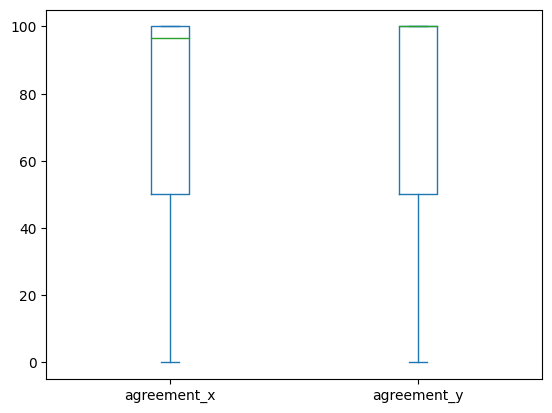

In [18]:
agreements[['agreement_x', 'agreement_y']].plot.box()

In [19]:
agreements['support_x'].value_counts()

support_x
1     32
2     13
4      8
3      6
7      3
9      3
5      2
16     1
8      1
14     1
Name: count, dtype: int64

<Axes: xlabel='support'>

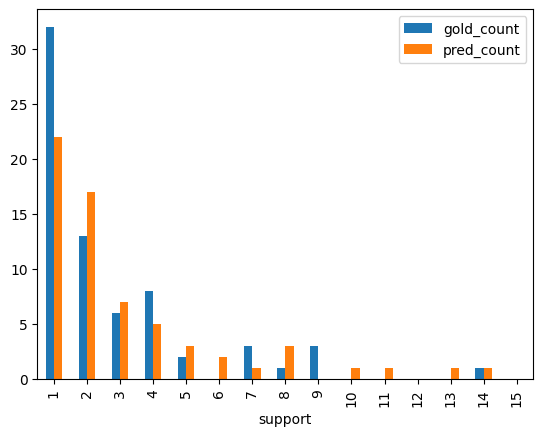

In [20]:
support_x_count = agreements.groupby('support_x')['speaker'].count()
support_y_count = agreements.groupby('support_y')['speaker'].count()


rows = []
for i in range(1, max(support_x_count.index.max(), support_y_count.index.max())):
    row = [i, 0, 0]
    if i in support_x_count:
        row[1] = support_x_count[i]
    if i in support_y_count:
        row[2] = support_y_count[i]
    rows.append(row)
pd.DataFrame(rows, columns=['support', 'gold_count', 'pred_count']).plot.bar('support')

In [21]:
agreements['support_y'].value_counts()

support_y
1.0     22
2.0     17
3.0      7
4.0      5
5.0      3
8.0      3
6.0      2
13.0     1
16.0     1
10.0     1
11.0     1
7.0      1
14.0     1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

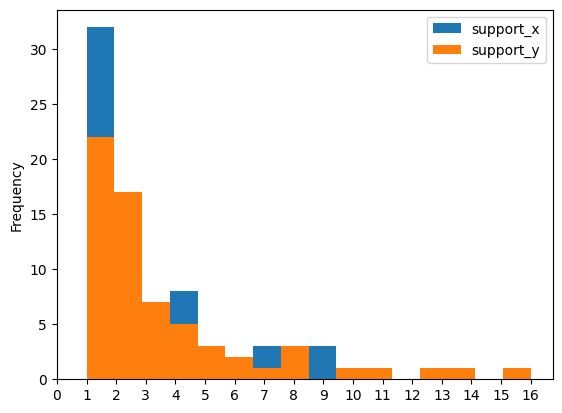

In [22]:
agreements[['support_x', 'support_y']].plot.hist(stacked=False, bins=16, xticks=list(range(17)))

In [23]:
agreements['delta'] = agreements.apply(lambda x: abs(x['agreement_x'] - x['agreement_y']), axis=1)

In [24]:
agreements['delta'].describe()

count     65.000000
mean      25.721692
std       29.820404
min        0.000000
25%        0.000000
50%       16.670000
75%       50.000000
max      100.000000
Name: delta, dtype: float64

<Axes: >

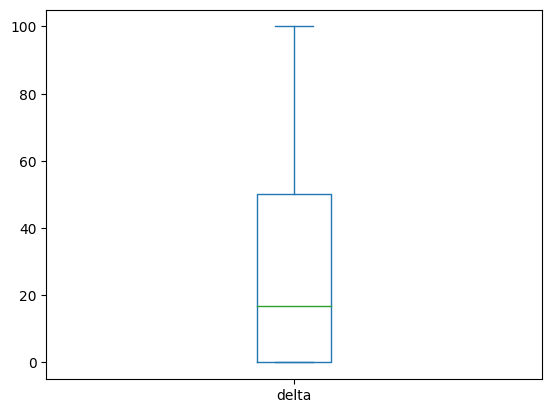

In [25]:
agreements['delta'].plot.box()

<Axes: xlabel='support_x', ylabel='delta'>

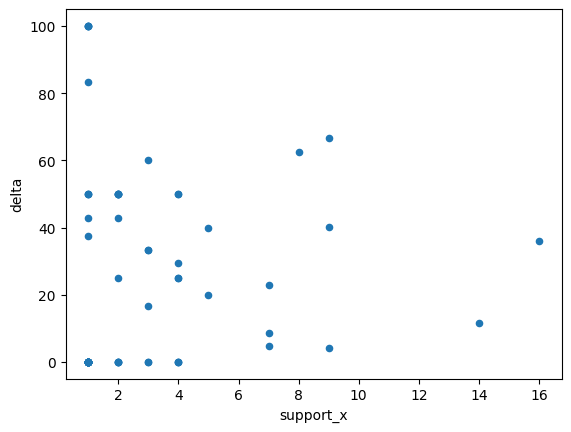

In [26]:
agreements.plot.scatter('support_x', 'delta')

In [27]:
agreements[['support_x', 'support_y', 'delta']].corr()

,support_x,support_y,delta
support_x,1.000000,0.673327,0.037783
support_y,0.673327,1.000000,0.149757
delta,0.037783,0.149757,1.000000


In [28]:
agreements[['support_x', 'support_y', 'delta']].corr('kendall')

,support_x,support_y,delta
support_x,1.000000,0.640909,0.155566
support_y,0.640909,1.000000,0.294501
delta,0.155566,0.294501,1.000000


In [29]:
agreements[['support_x', 'support_y', 'delta']].corr('spearman')

,support_x,support_y,delta
support_x,1.000000,0.716269,0.210856
support_y,0.716269,1.000000,0.395318
delta,0.210856,0.395318,1.000000


In [30]:
def normalize(item):
  t = sum([v for v in item.values()])
  for k in item:
    item[k] /= t

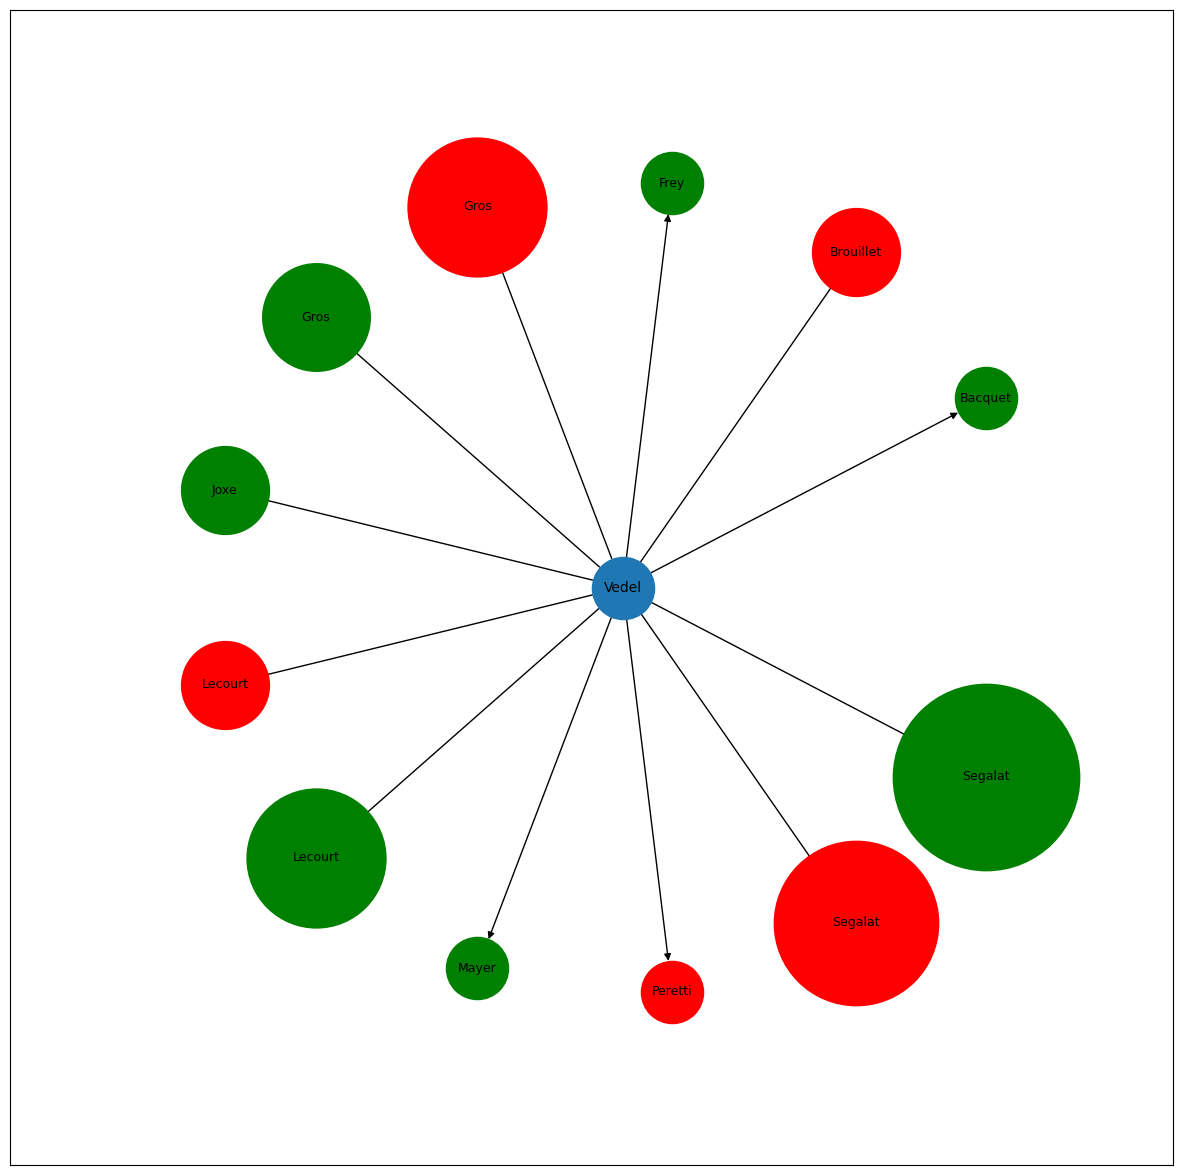

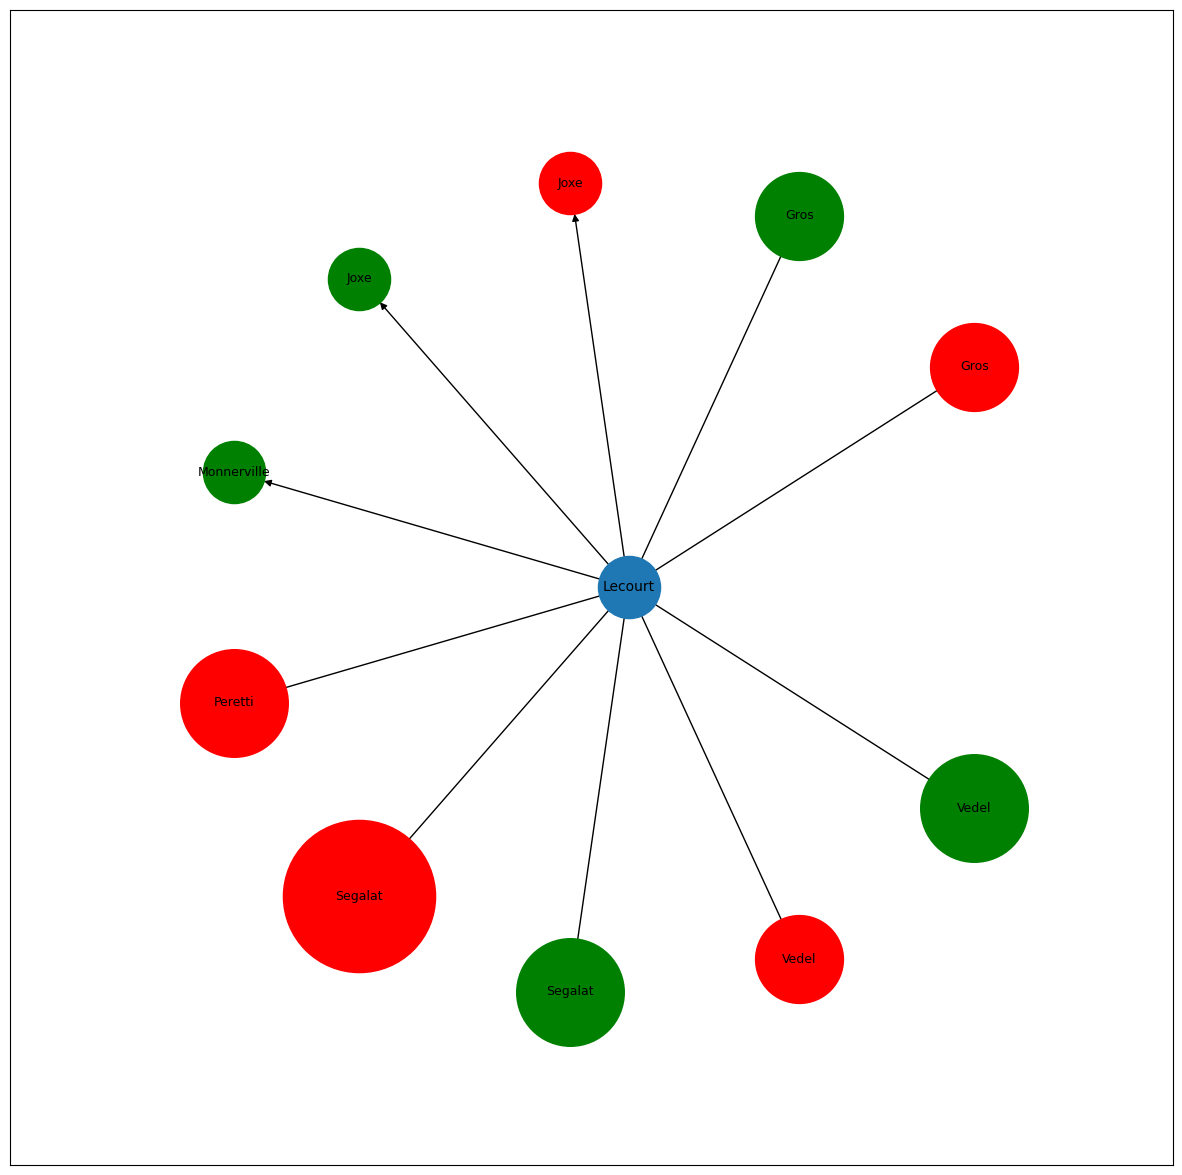

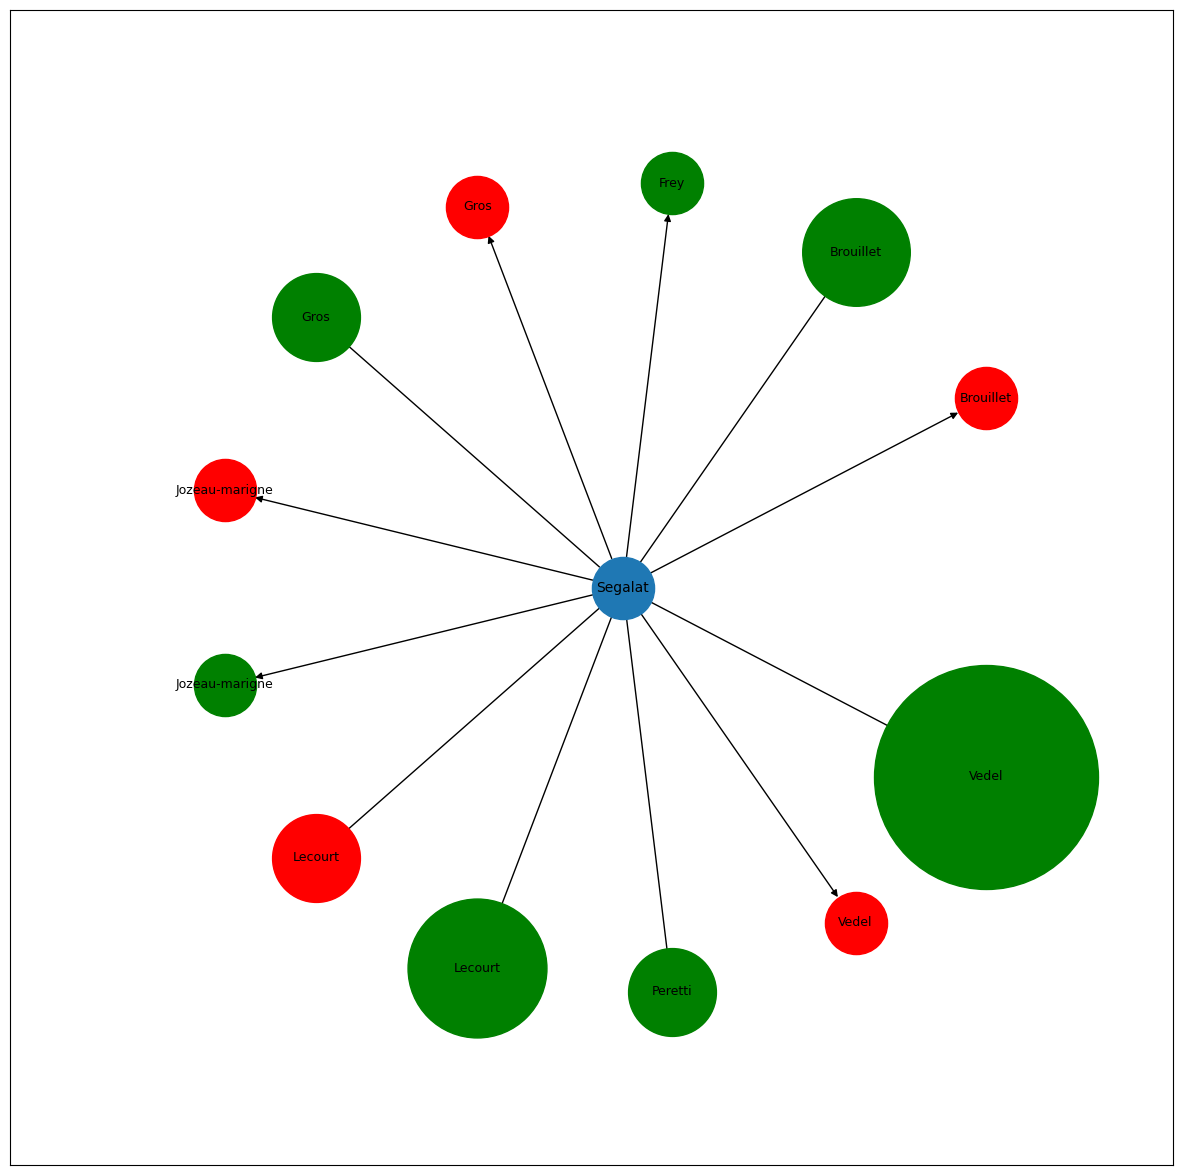

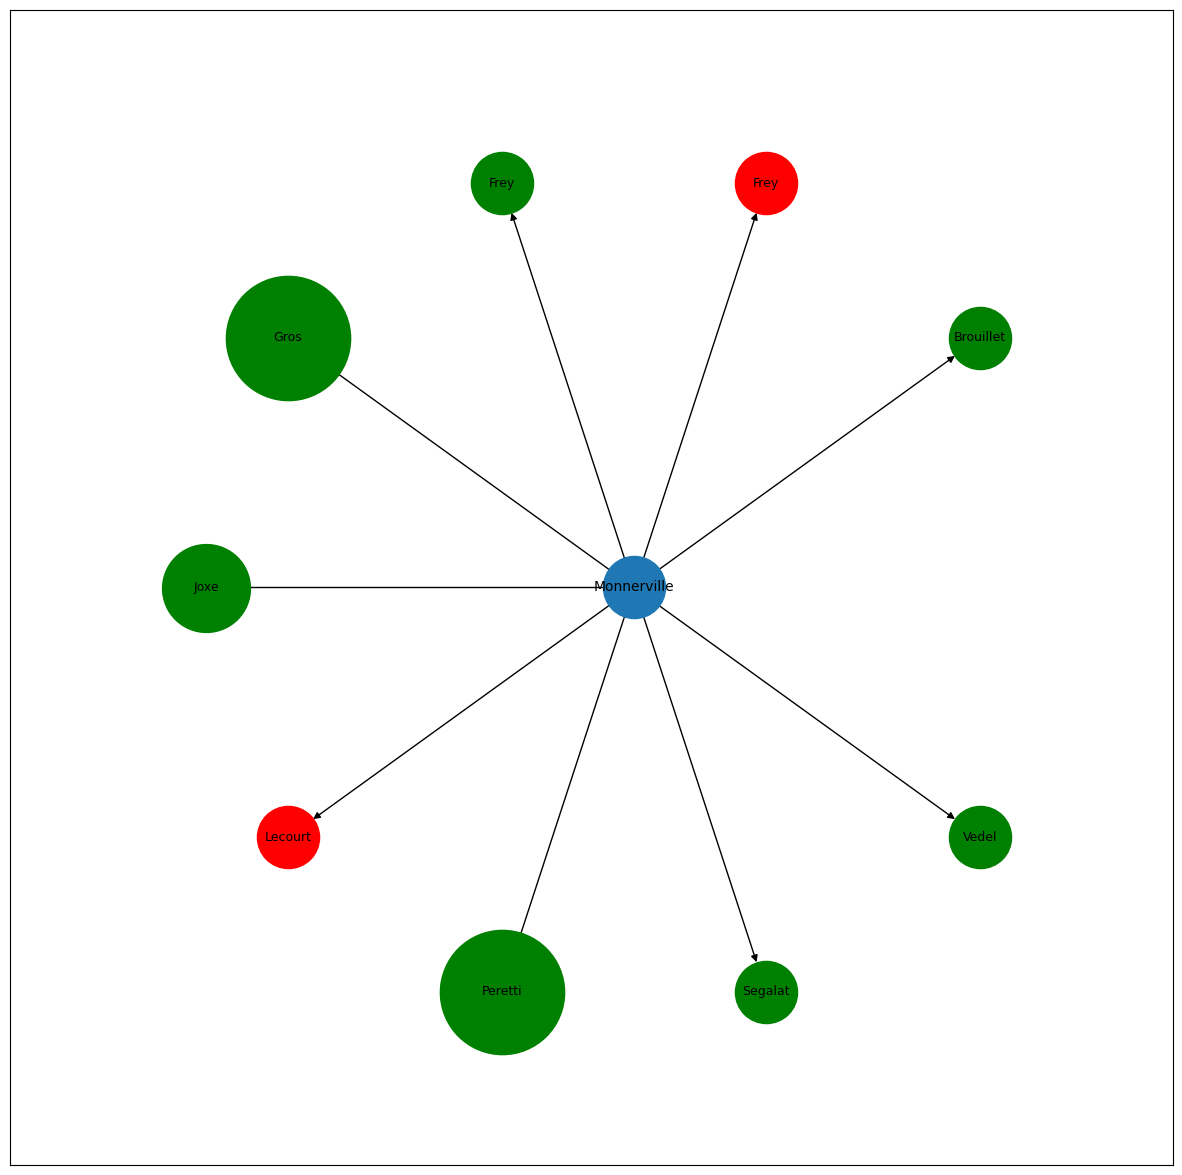

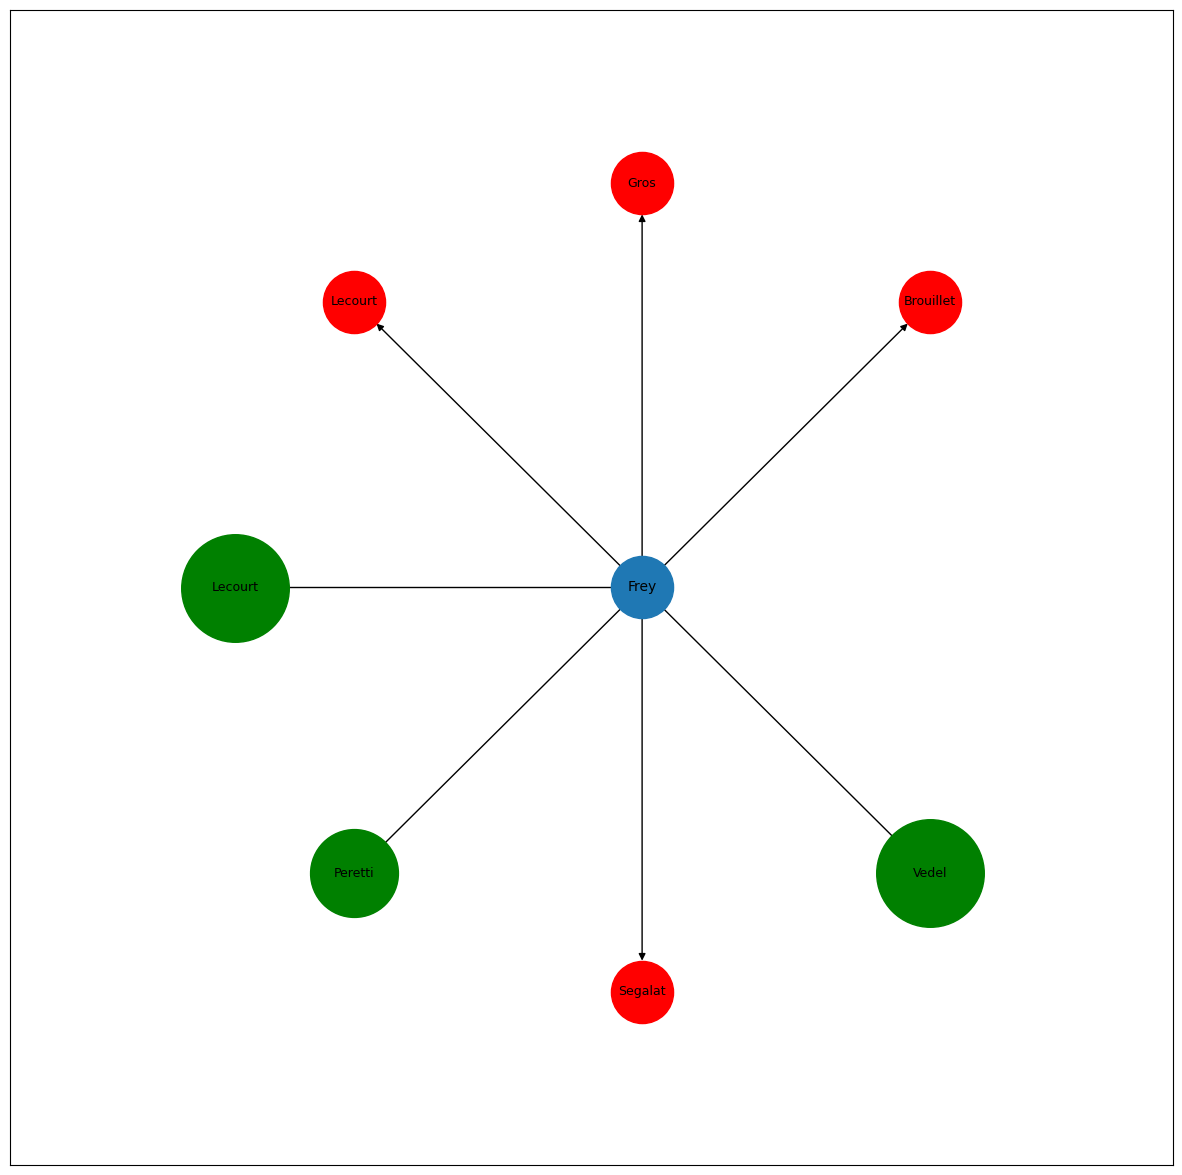

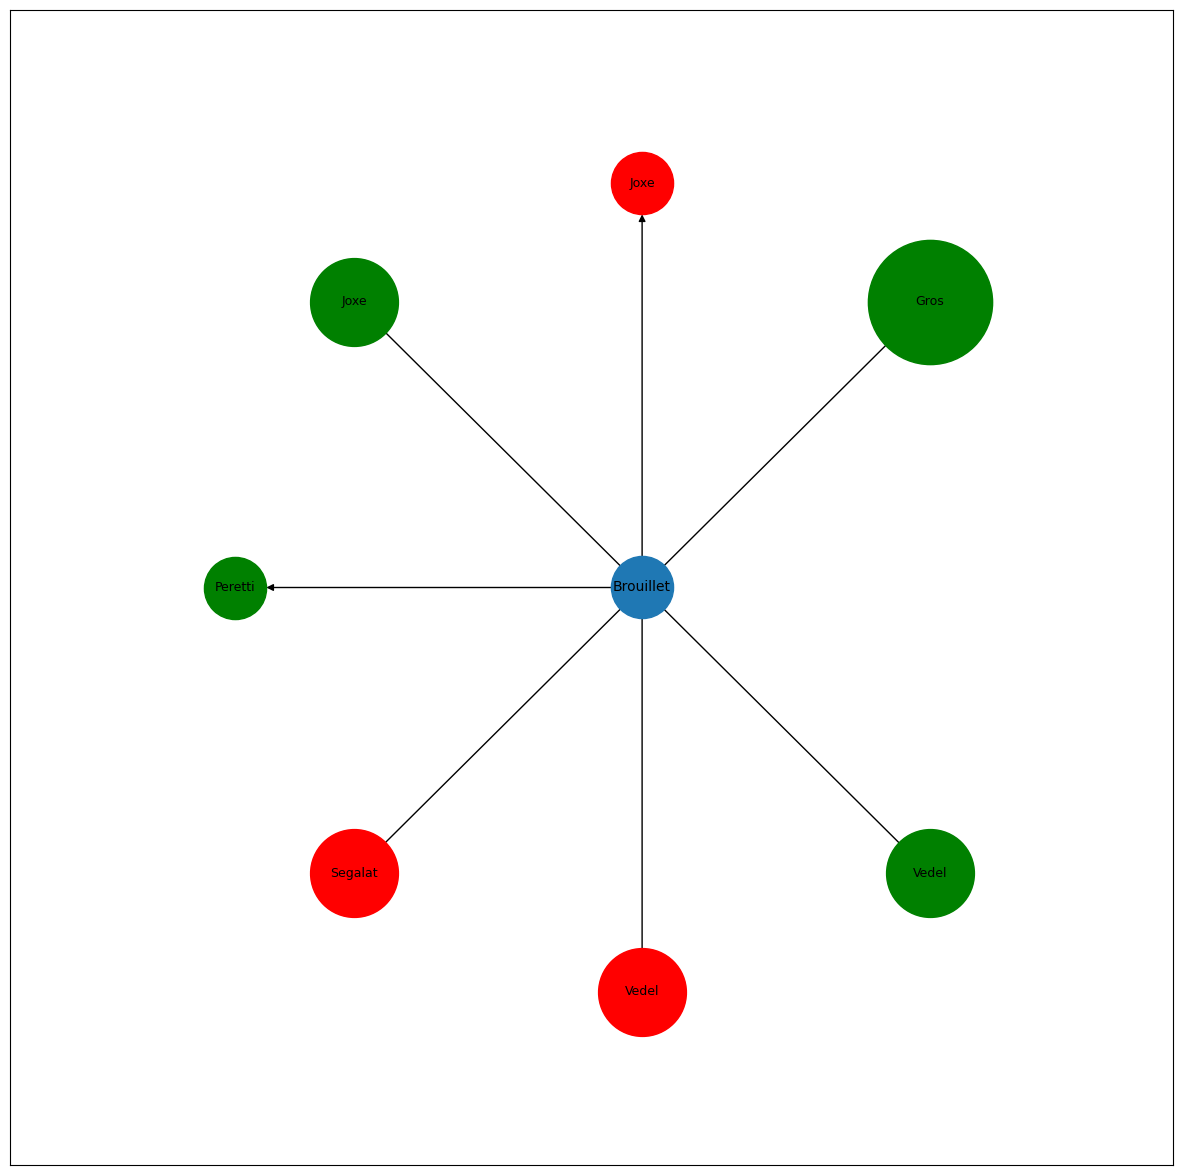

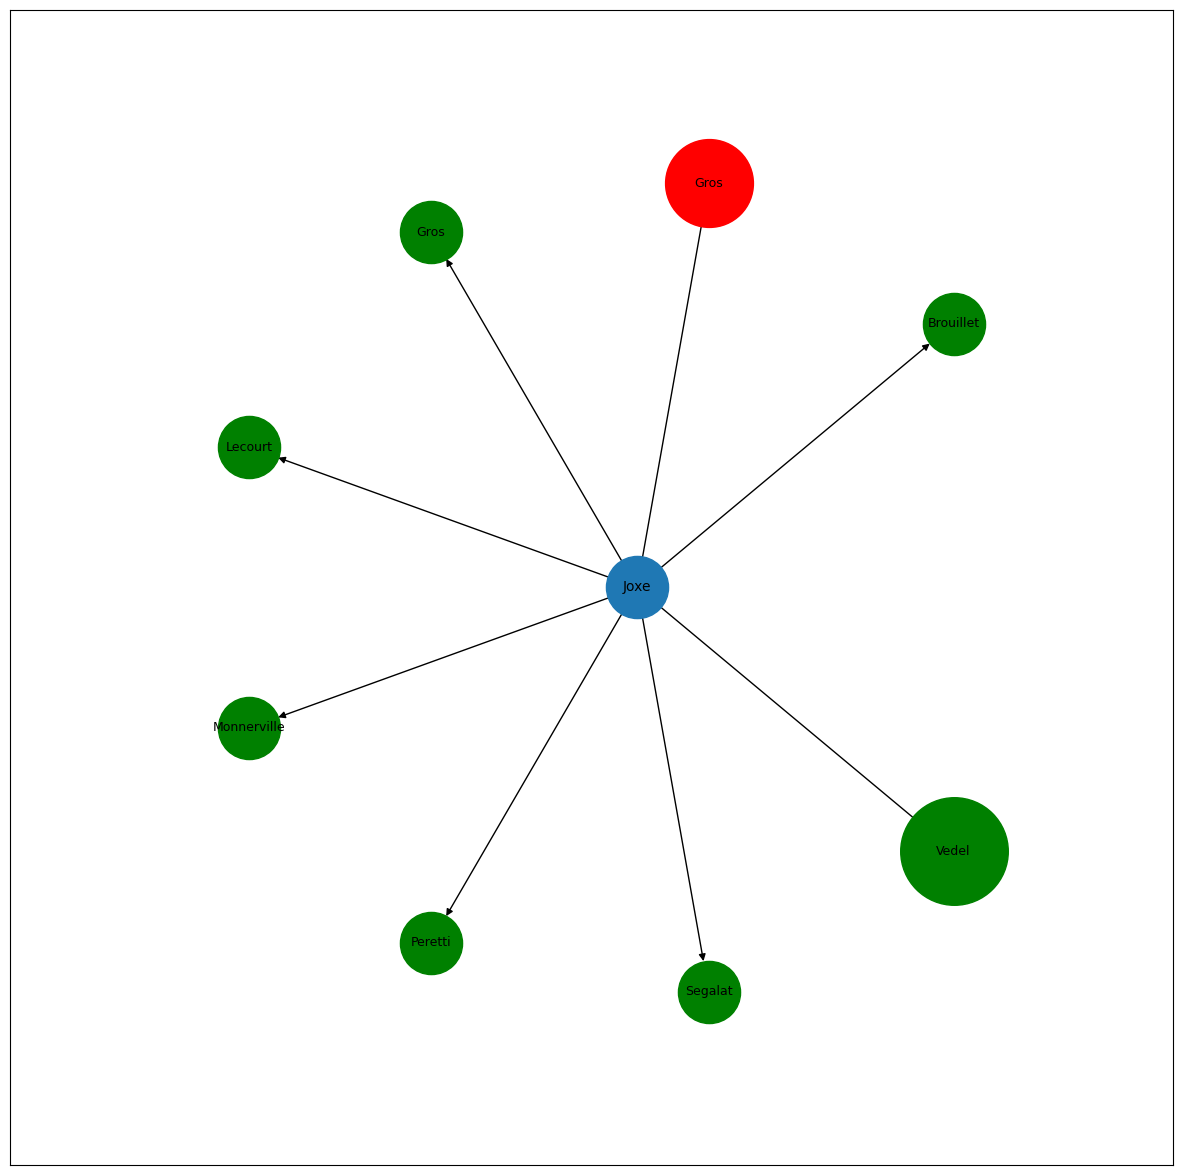

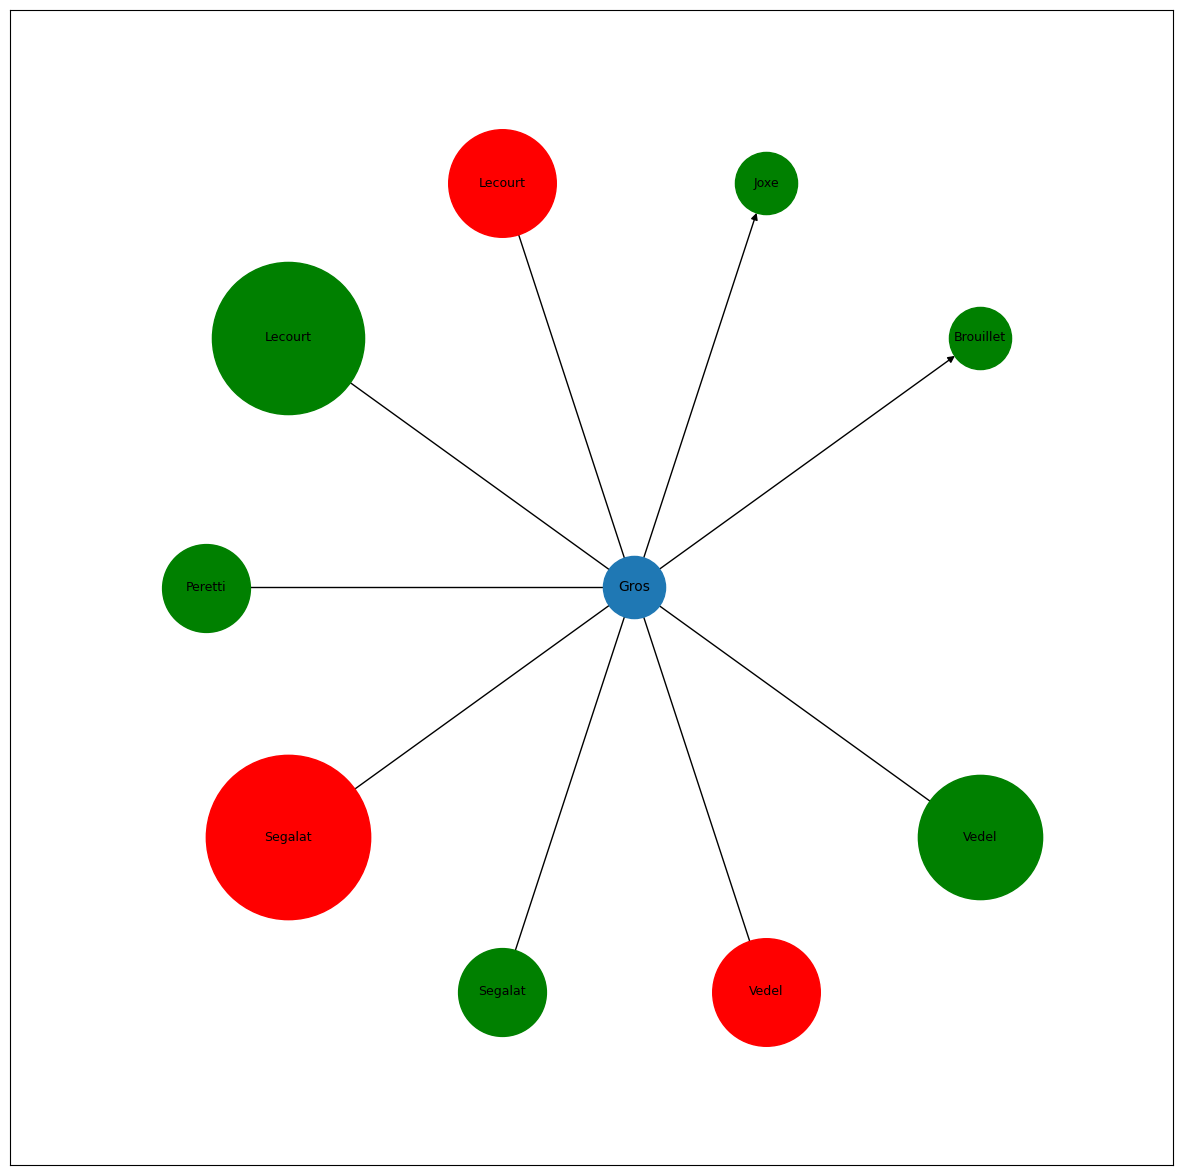

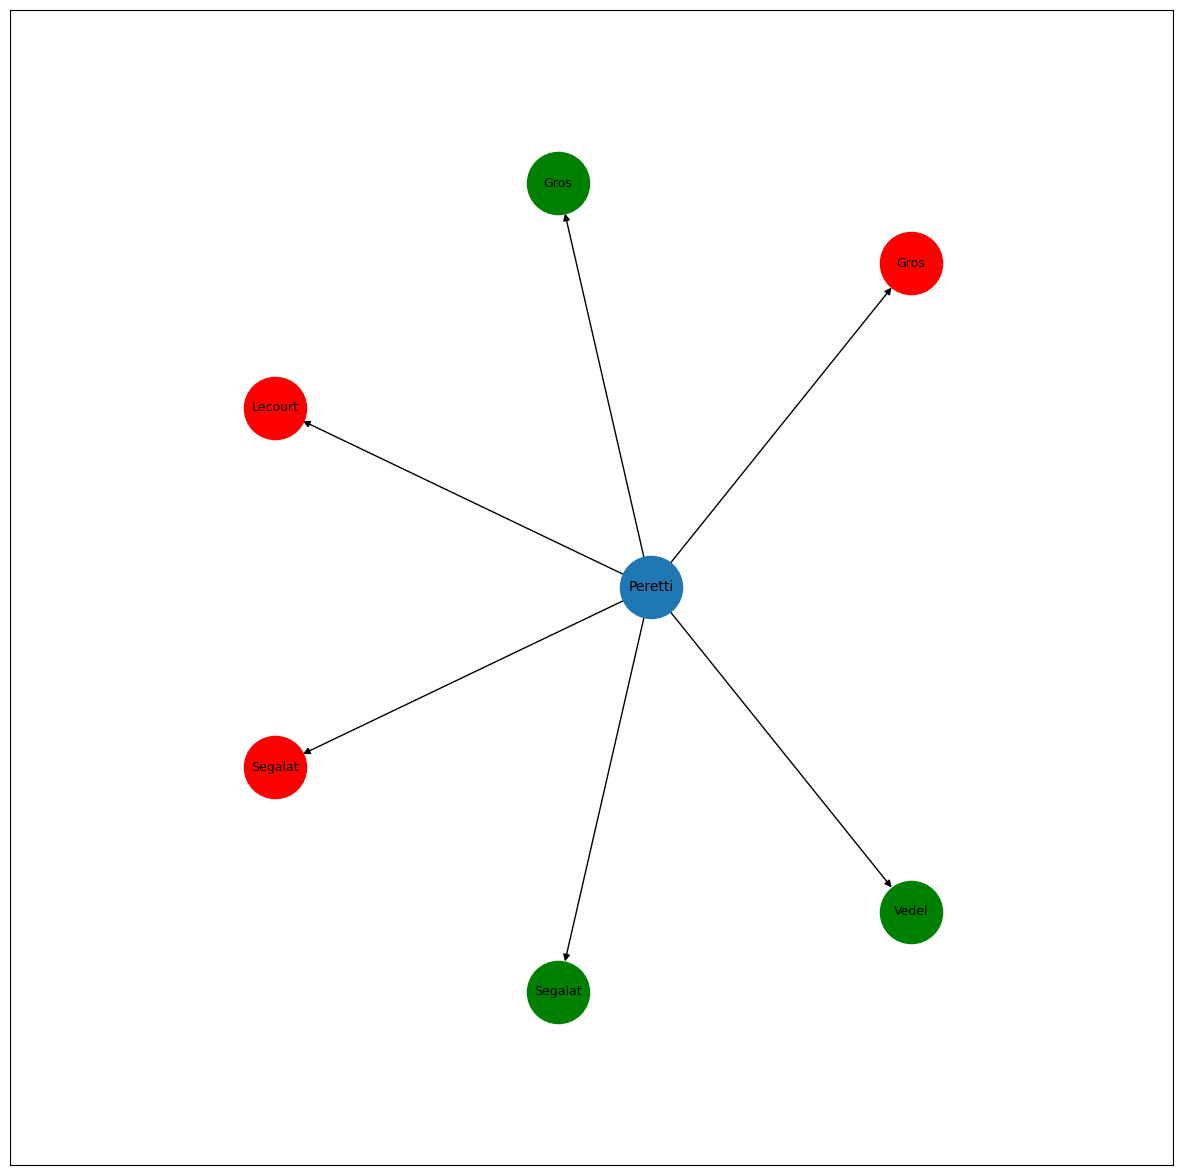

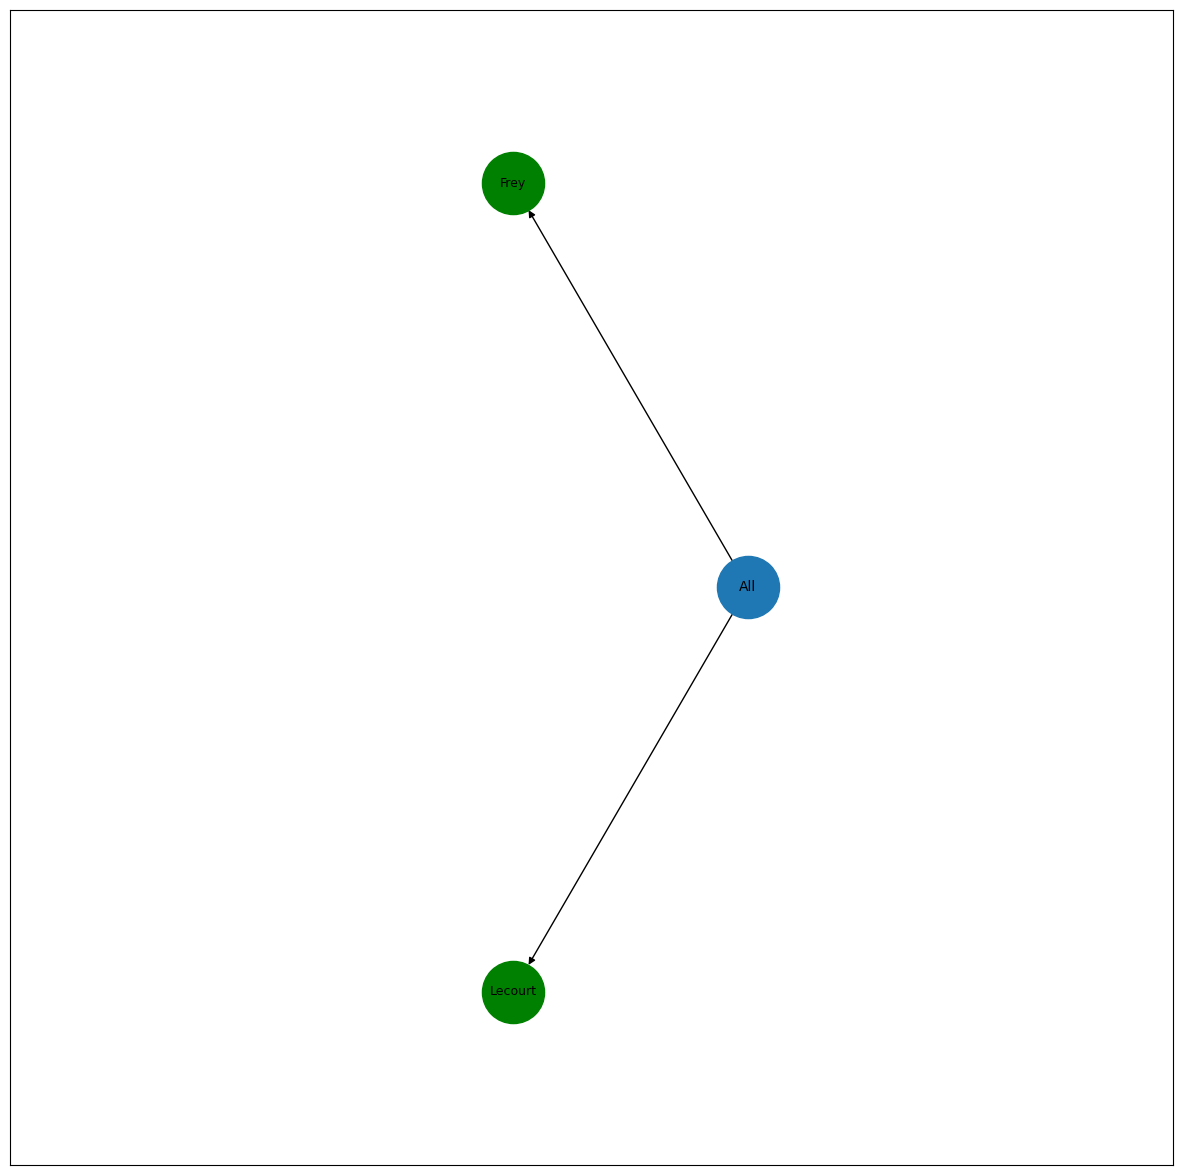

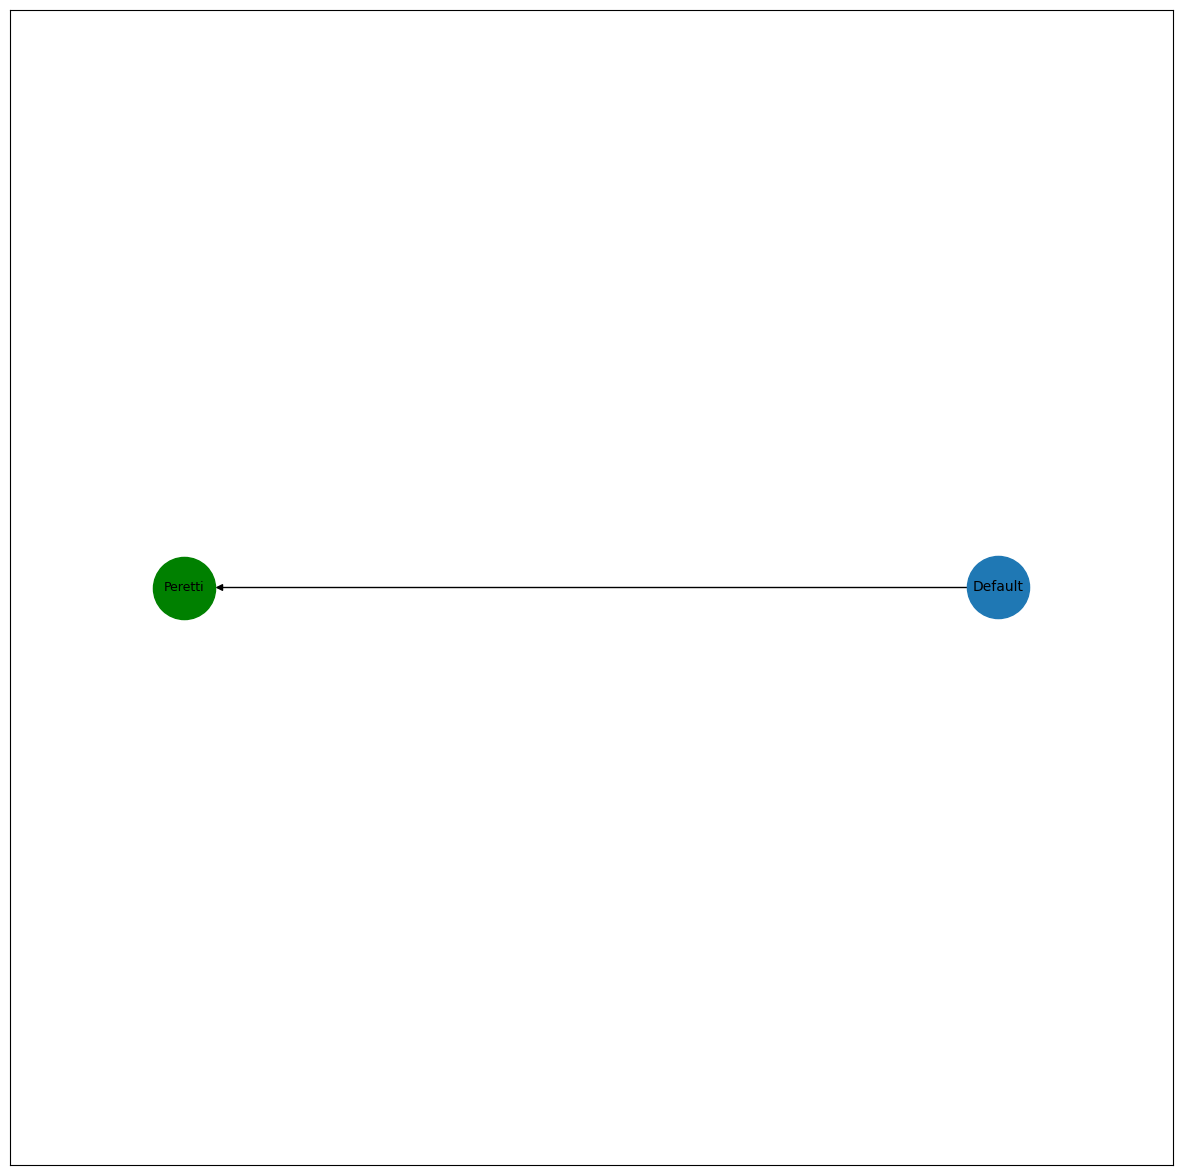

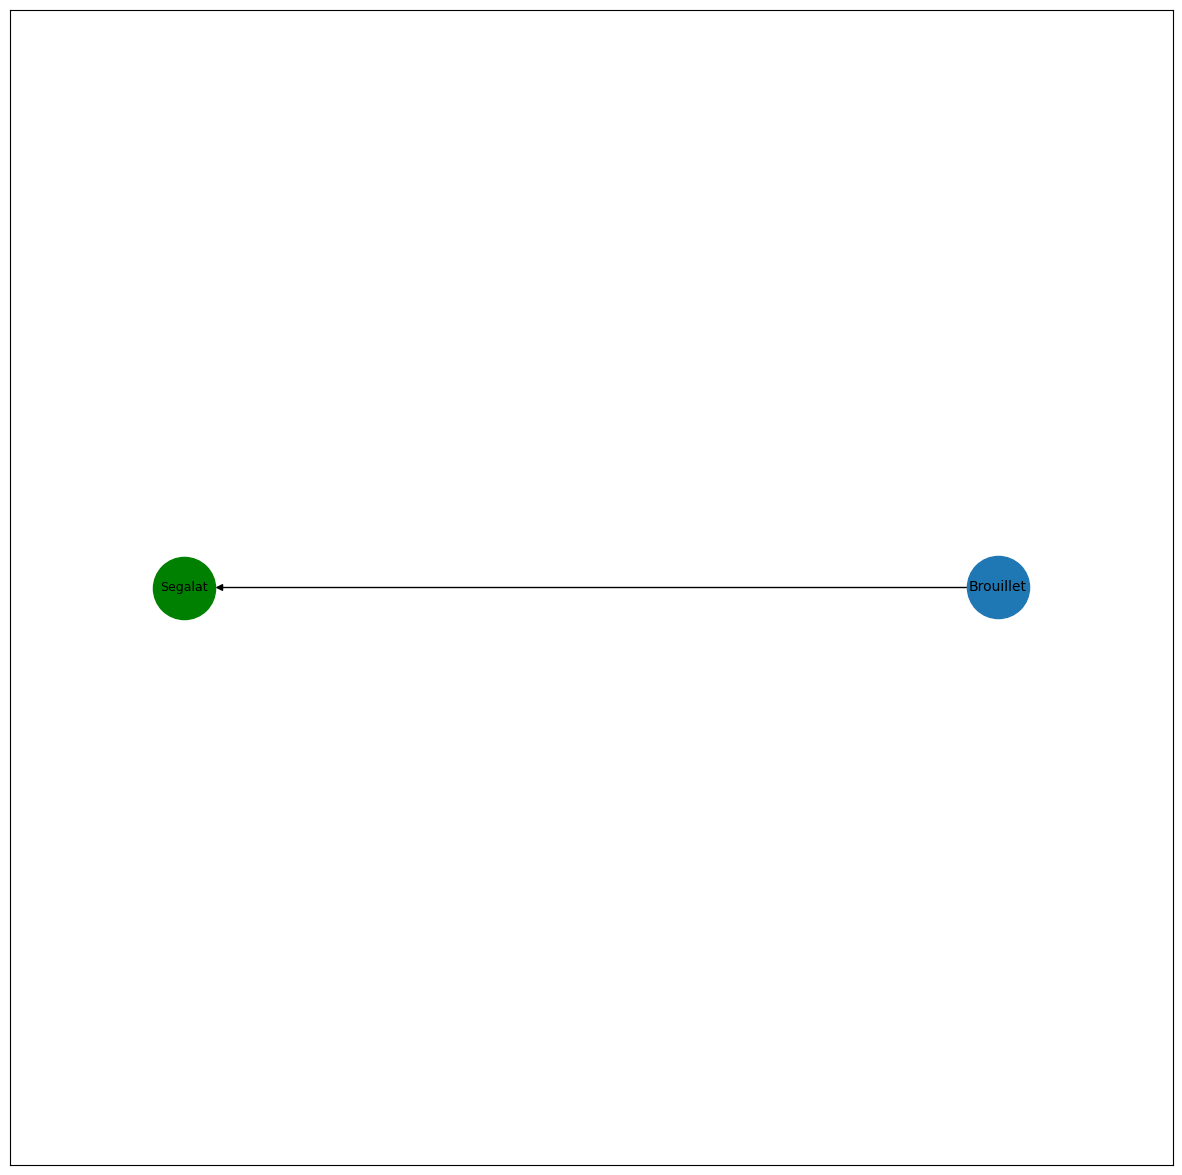

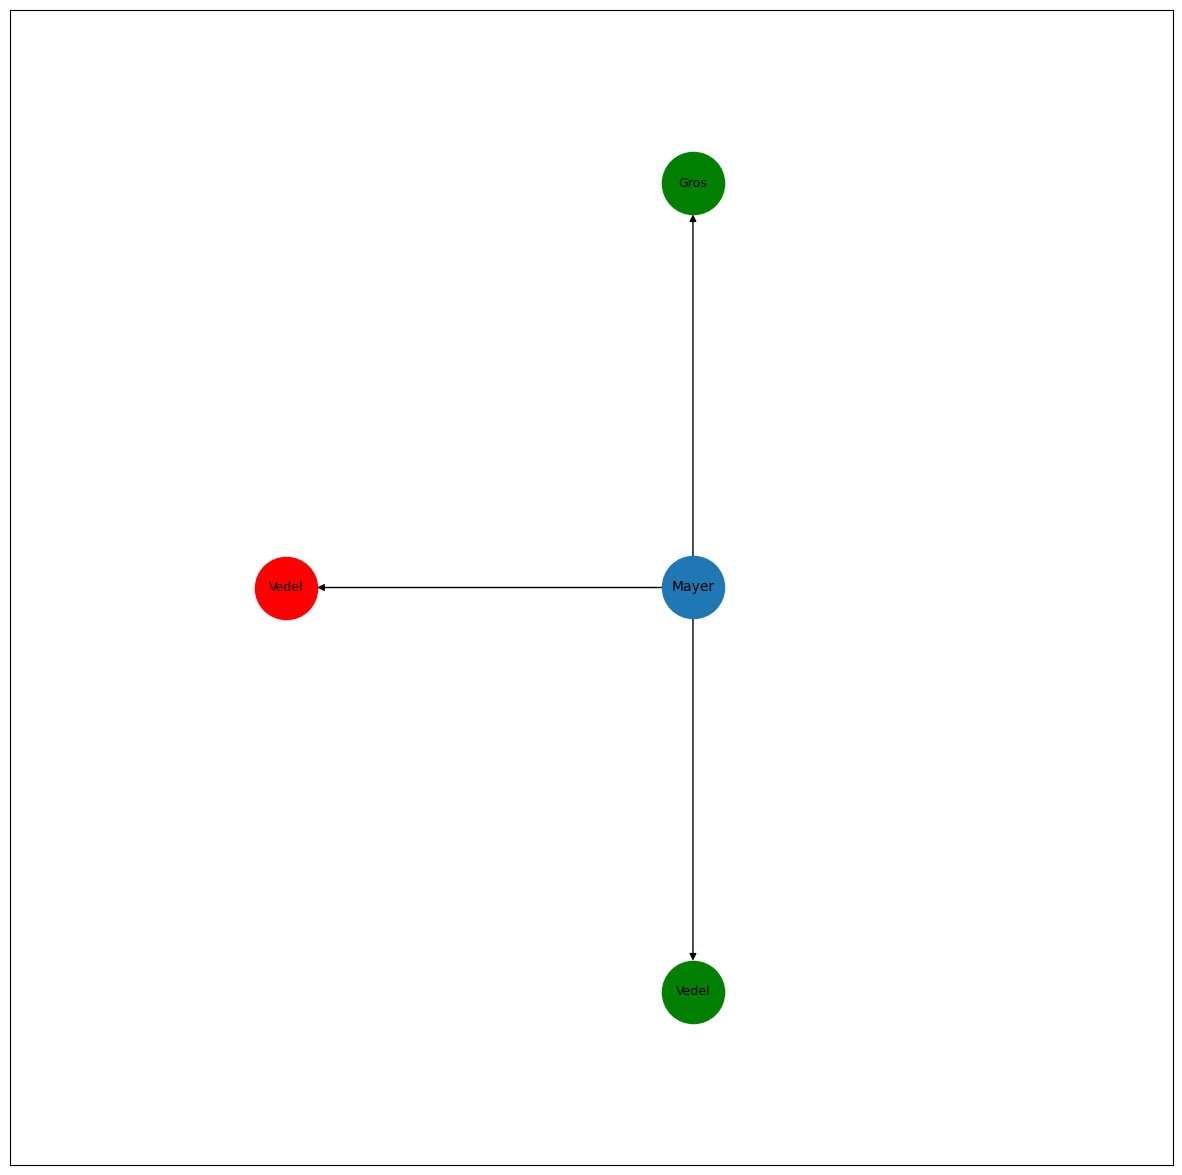

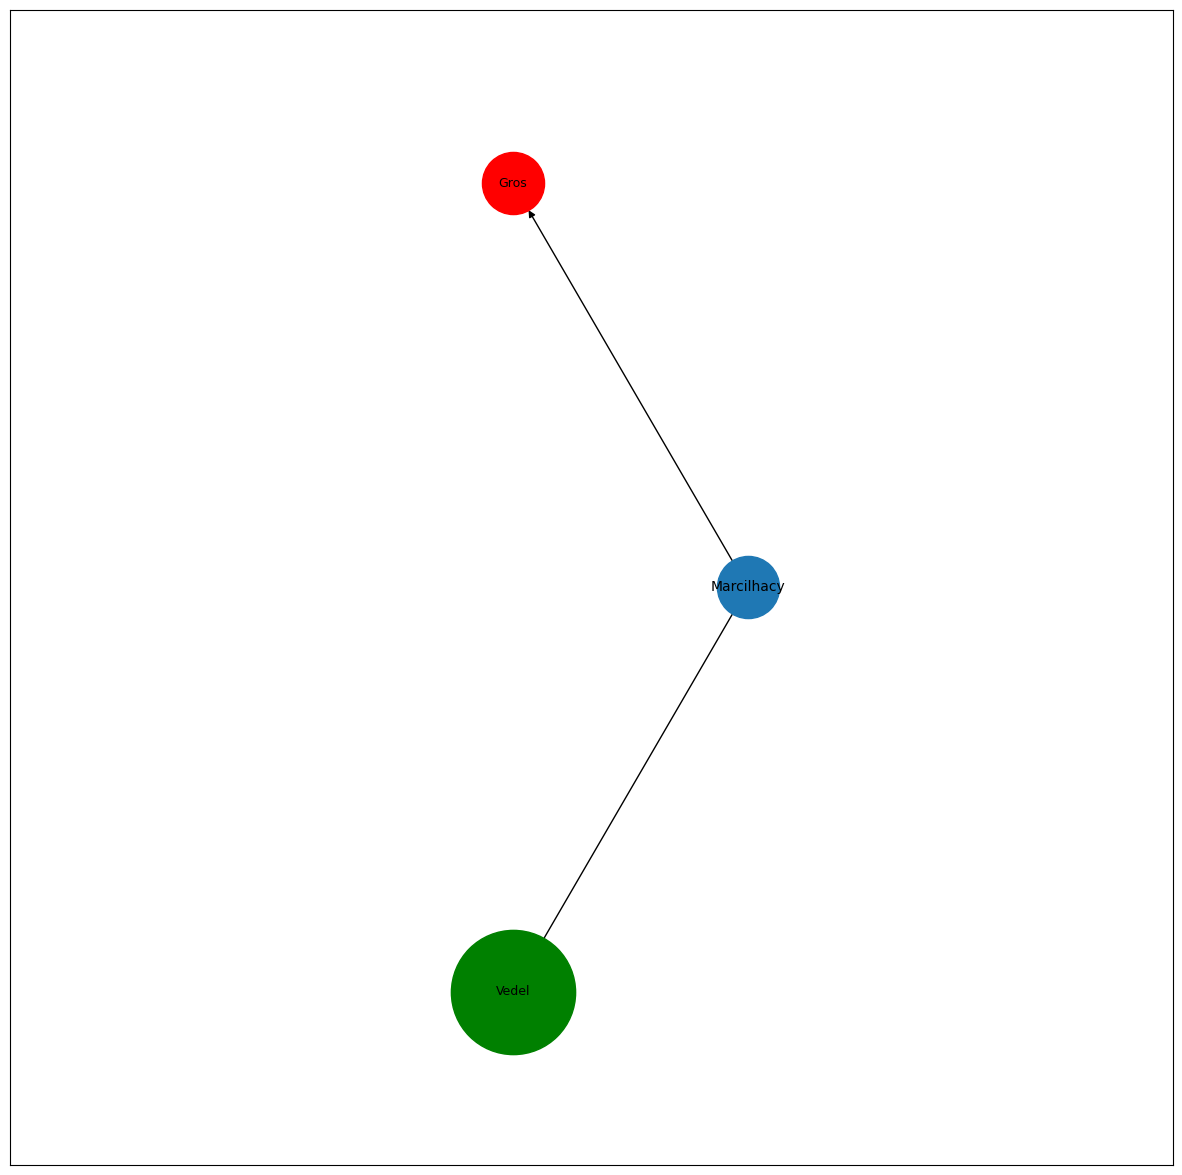

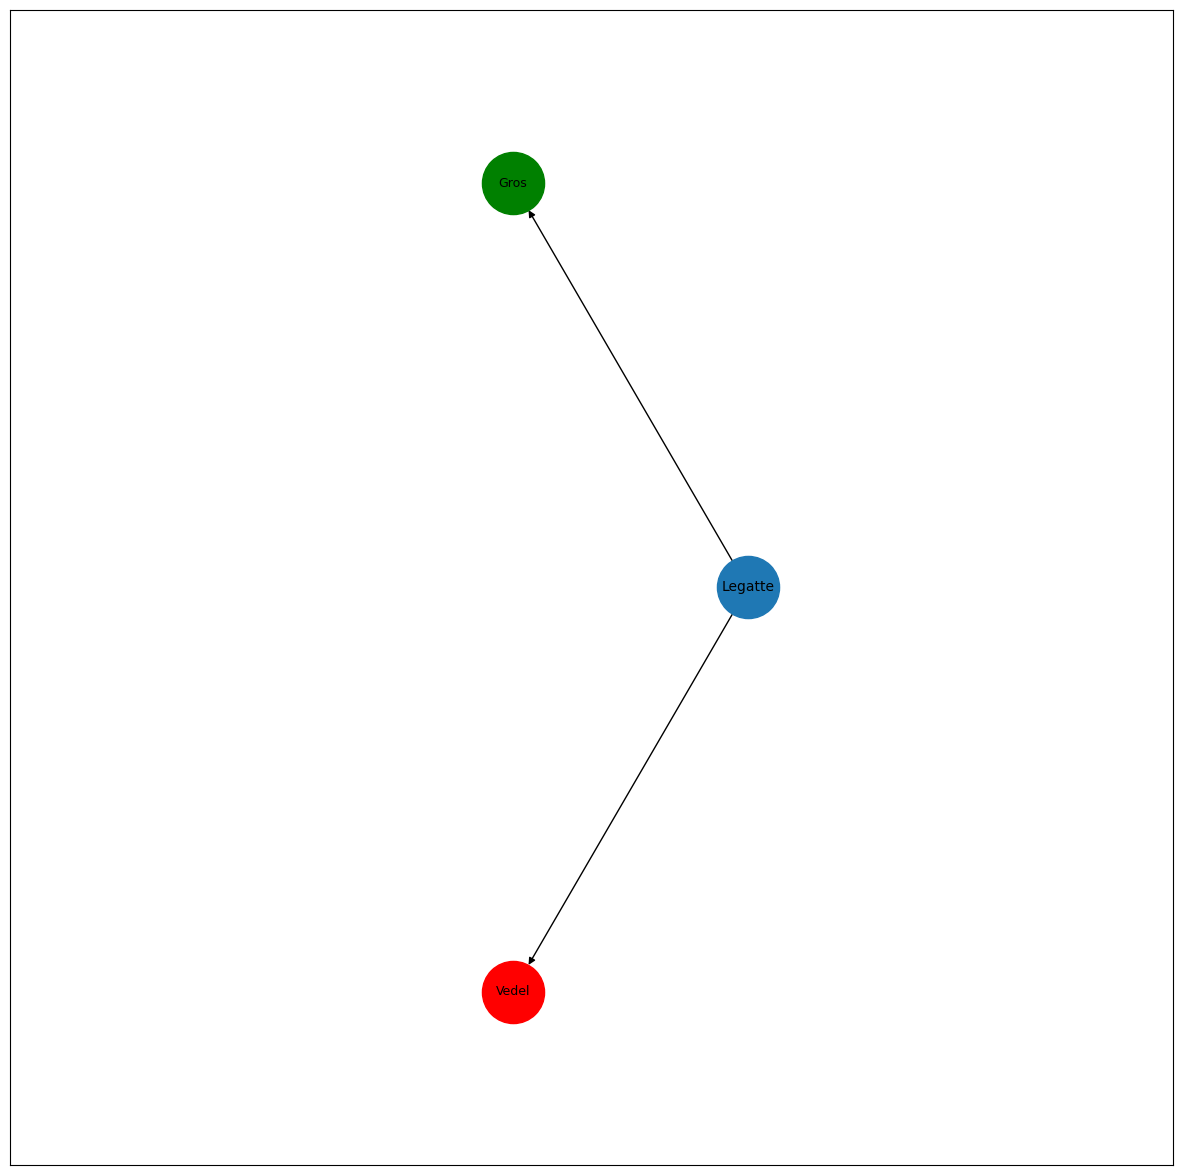

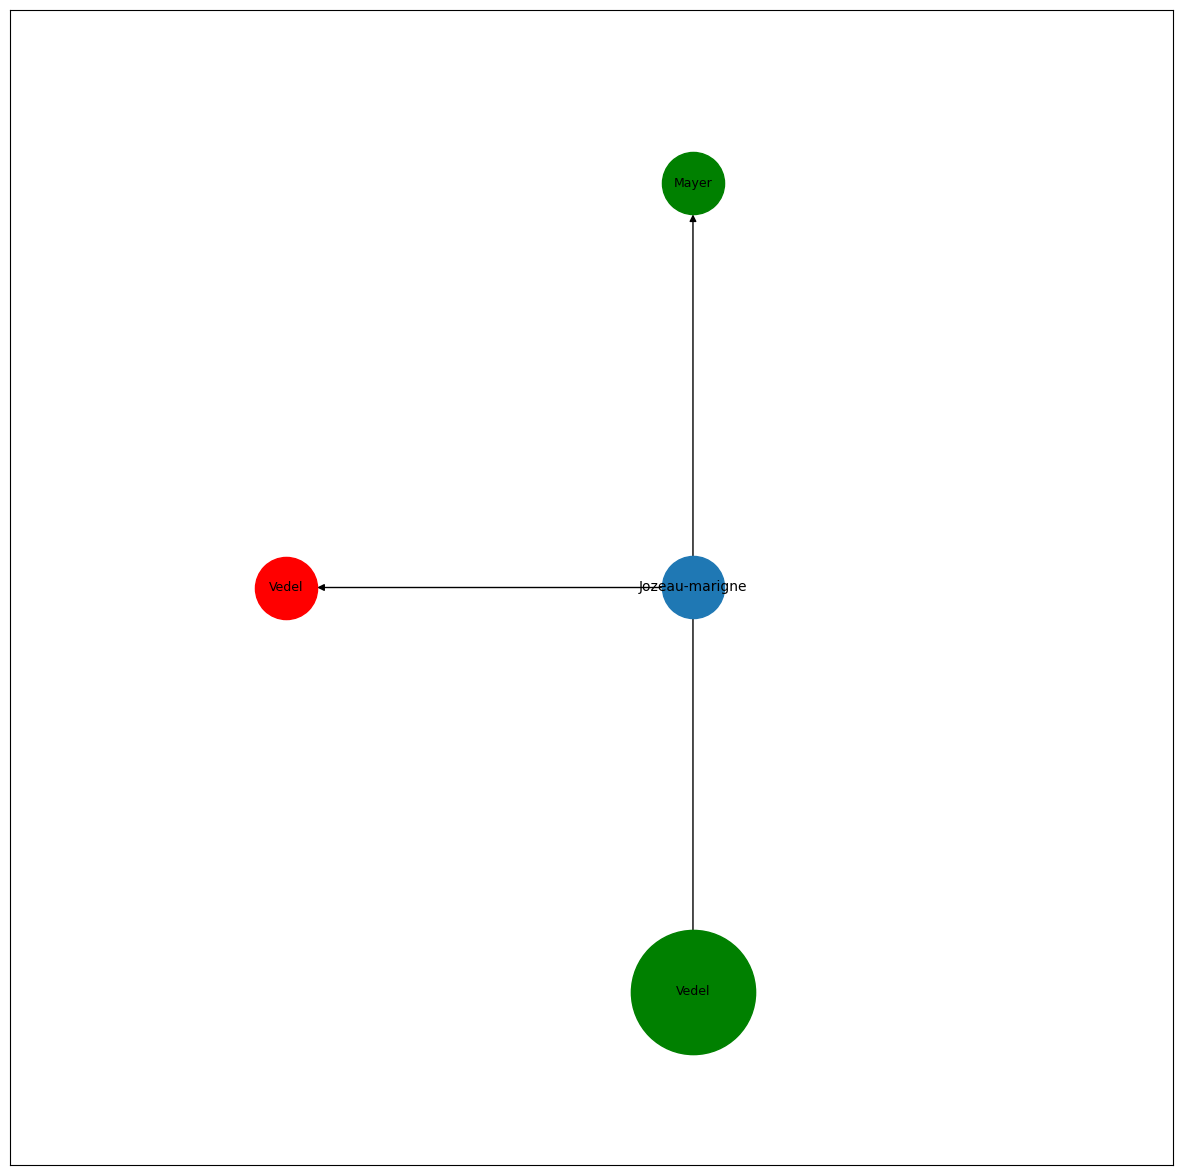

In [31]:
scale = 2000

for speaker in df_golds.speaker.unique():
    plt.figure(figsize=(15,15)) 
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    df_sp = df_golds[df_golds['speaker']==speaker]

    d = defaultdict(dict)
    for n in df_sp.groupby(['target', 'type']).count().iterrows():
        d[n[0][0]][n[0][1]]=n[1][0]

    G = nx.DiGraph()
    for k, v in d.items():
        for kk, vv in v.items():
            G.add_edge(speaker, k+kk)

    pos = nx.circular_layout(G, center=[0,0])
    pos[speaker]=[0,0]
    pos = nx.rescale_layout_dict(pos, .7)

    nx.draw_networkx_nodes(G, pos, nodelist=[speaker], node_size=scale)
    nx.draw_networkx_labels(G, pos, labels={speaker:speaker[1:].split('_')[0].capitalize()}, font_size=10)
    for k, v in d.items():
        for kk, vv in v.items():
            nx.draw_networkx_nodes(G, pos, nodelist=[k+kk], node_color='green' if kk=='POSITIF' else 'red', node_size=vv*scale)
            # nx.draw_networkx_edges(G, pos, edgelist=[(speaker,k+kk)], node_size=vv*scale, connectionstyle="arc3,rad=0.45")
            nx.draw_networkx_edges(G, pos, edgelist=[(speaker,k+kk)], node_size=scale)
            nx.draw_networkx_labels(G, pos, labels={k+kk:k[1:].split('_')[0].capitalize()}, font_size=9)
    plt.show()